# Zillow Analysis

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

## Business Problem

A real estate investment firm is interested in knowing the top five best New Jersey zip codes to invest in based on return on investment (ROI) and risk.  

## Load Data for Analysis

In [2]:
df = pd.read_csv('data/zillow_data.csv')

In [3]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [17]:
df.shape

(14723, 272)

## Data Preprocessing

In [41]:
#Convert date columns to datetime objects
def get_datetimes(df):
    non_dt_cols = []
    dt_cols = []
    
    for c in df.columns:
        if c[0].isnumeric():
            dt_cols.append(c)
        else:
            non_dt_cols.append(c)
    #print(non_dt_cols)
    #print(dt_cols)
    dt_cols = list(pd.to_datetime(dt_cols, format = '%Y-%m'))
    
    df.columns = non_dt_cols + dt_cols
    return df

In [5]:
df = get_datetimes(df)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## EDA and Visualization

In [6]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

## Reshape from Wide to Long Format

In [42]:
#Function to melt dataframe with datetime columns
def melt_data(df):
    melted = pd.melt(
        df,
        id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],
        var_name='time')
    melted = melted.dropna(subset=['value'])
    return melted

In [43]:
#Updated dataframe
melted_df = melt_data(df)
melted_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
...,...,...,...,...,...,...,...,...,...
3901590,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,2018-04-01,209300.0
3901591,59107,3293,Woodstock,NH,Claremont,Grafton,14720,2018-04-01,225800.0
3901592,75672,40404,Berea,KY,Richmond,Madison,14721,2018-04-01,133400.0
3901593,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,2018-04-01,664400.0


In [9]:
#Select NJ data for analysis
melted_df[melted_df['State'] == 'NJ']

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
57,60545,7030,Hoboken,NJ,New York,Hudson,58,1996-04-01,301600.0
73,61148,8701,Lakewood,NJ,New York,Ocean,74,1996-04-01,153800.0
158,61169,8753,Toms River,NJ,New York,Ocean,159,1996-04-01,123400.0
187,60518,7002,Bayonne,NJ,New York,Hudson,188,1996-04-01,145000.0
191,60639,7302,Jersey City,NJ,New York,Hudson,192,1996-04-01,137200.0
...,...,...,...,...,...,...,...,...,...
3901341,61046,8319,Estell Manor,NJ,Atlantic City,Atlantic,14470,2018-04-01,188800.0
3901383,60903,8006,Barnegat Light,NJ,New York,Ocean,14512,2018-04-01,795200.0
3901409,61054,8328,Franklin,NJ,Philadelphia,Gloucester,14538,2018-04-01,161300.0
3901504,61044,8317,Weymouth,NJ,Atlantic City,Atlantic,14633,2018-04-01,165000.0


In [44]:
#Check unique county names
melted_df[melted_df['State'] == 'NJ']['CountyName'].unique()

array(['Hudson', 'Ocean', 'Middlesex', 'Somerset', 'Monmouth', 'Passaic',
       'Essex', 'Camden', 'Bergen', 'Burlington', 'Union', 'Mercer',
       'Morris', 'Atlantic', 'Gloucester', 'Cumberland', 'Warren',
       'Hunterdon', 'Cape May', 'Sussex', 'Salem'], dtype=object)

In [45]:
#Create Bergen County dataframe
bergen_df = melted_df[(melted_df['State'] == 'NJ') & (melted_df['CountyName'] == 'Bergen')]
bergen_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
832,60714,7601,Hackensack,NJ,New York,Bergen,833,1996-04-01,157500.0
947,60540,7024,Fort Lee,NJ,New York,Bergen,948,1996-04-01,260200.0
2343,60750,7666,Teaneck,NJ,New York,Bergen,2344,1996-04-01,170800.0
3203,60656,7410,Fair Lawn,NJ,New York,Bergen,3204,1996-04-01,180500.0
3953,60729,7631,Englewood,NJ,New York,Bergen,3954,1996-04-01,163300.0
...,...,...,...,...,...,...,...,...,...
3898856,60664,7423,Ho Ho Kus,NJ,New York,Bergen,11985,2018-04-01,714100.0
3899766,60732,7641,Haworth,NJ,New York,Bergen,12895,2018-04-01,654000.0
3900002,60583,7074,Moonachie,NJ,New York,Bergen,13131,2018-04-01,348100.0
3900356,60719,7606,South Hackensack,NJ,New York,Bergen,13485,2018-04-01,403600.0


In [46]:
#Create Passaic County dataframe
passaic_df = melted_df[(melted_df['State'] == 'NJ') & (melted_df['CountyName'] == 'Passaic')]
passaic_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
622,60565,7055,Passaic,NJ,New York,Passaic,623,1996-04-01,133100.0
840,60688,7470,Wayne,NJ,New York,Passaic,841,1996-04-01,240400.0
3128,60527,7011,Clifton,NJ,New York,Passaic,3129,1996-04-01,147600.0
3968,60529,7013,Clifton,NJ,New York,Passaic,3969,1996-04-01,170800.0
4044,60694,7501,Paterson,NJ,New York,Passaic,4045,1996-04-01,105400.0
...,...,...,...,...,...,...,...,...,...
3896345,60653,7403,Bloomingdale,NJ,New York,Passaic,9474,2018-04-01,287200.0
3896846,60706,7513,Paterson,NJ,New York,Passaic,9975,2018-04-01,257100.0
3896856,60687,7465,Wanaque,NJ,New York,Passaic,9985,2018-04-01,334800.0
3897855,60530,7014,Clifton,NJ,New York,Passaic,10984,2018-04-01,364500.0


In [19]:
#Check unique cities for Passaic County
passaic_df.City.unique()

array(['Passaic', 'Wayne', 'Clifton', 'Paterson', 'Little Falls',
       'North Haledon', 'Hawthorne', 'West Milford', 'Ringwood',
       'Pompton Lakes', 'Totowa', 'Bloomingdale', 'Wanaque'], dtype=object)

In [21]:
#Take the mean of each Passaic County value
passaic_df.groupby('time').aggregate({'value':'mean'})

,value
time,
1996-04-01,149352.0
1996-05-01,149192.0
1996-06-01,149036.0
1996-07-01,148872.0
1996-08-01,148736.0
...,...
2017-12-01,286644.0
2018-01-01,289556.0
2018-02-01,293160.0


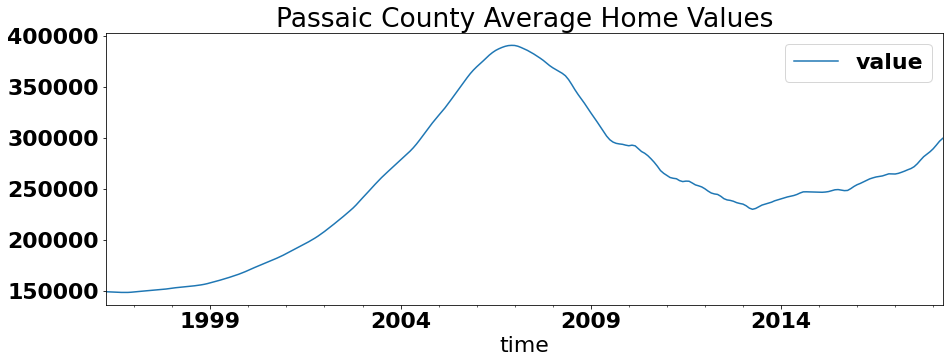

In [39]:
passaic_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Passaic County Average Home Values');

## ARIMA Modeling

## Interpreting Results